# Ситуация в биткоине

In [92]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

from matplotlib.ticker import ScalarFormatter
from datetime import date

In [93]:
ASSET = 'BTC-USD'

WEIGHTS = np.array([1])
ASSETS = [ASSET]

In [94]:
url_source = 'https://firebasestorage.googleapis.com/v0/b/buy-bitcoin-worldwide.appspot.com/o/prices%2Fhistoric%2Fbtc%2Fusd.json?alt=media'

json = requests.get(url_source).text

with open('history.json', 'w') as outfile:
    outfile.write(json)

In [95]:
column_index = pd.MultiIndex.from_tuples([('Close', ASSET), ('Dividends', ASSET)], names=['property', 'asset'])

history = pd.read_json('history.json')
history.date = pd.to_datetime(history.date)
history.set_index('date', inplace=True)
history['Dividends'] = 0.0
history.columns = column_index
history.head()

# history.info()
None

In [96]:
df = history[['Close', 'Dividends']]

## Изменения за выходные

In [97]:
changes = (df.diff(periods=2) / df.Close.shift(2)).dropna()
weekend_mask = [(ts.weekday() == 0) for ts in changes.index]
weekend_changes = changes[weekend_mask].Close * 100

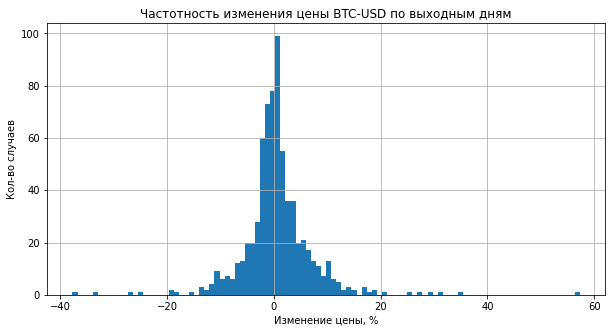

In [98]:

ax, = weekend_changes.hist(bins=100, figsize=(10, 5)).tolist()
plt.title('Частотность изменения цены BTC-USD по выходным дням')
plt.xlabel('Изменение цены, %')
plt.ylabel('Кол-во случаев')
# plt.xscale('symlog')
ax[0].xaxis.set_major_formatter(ScalarFormatter())

In [99]:
print(f'История {weekend_changes.index.min().date()} ... {weekend_changes.index.max().date()}')
print(f'Среднее изменение за выходные {weekend_changes.mean().iloc[0]:.2f}%')

История 2010-07-26 ... 2024-02-12
Среднее изменение за выходные 0.63%


In [100]:
weekend_changes.quantile([0.01, 0.05, 0.5, 0.95, 0.99]).rename_axis('квантиль').rename_axis('Изменение, %', axis=1)

"Изменение, %",BTC-USD
квантиль,
0.01,-15.435527
0.05,-8.738195
0.50,0.323226
0.95,10.441102
0.99,19.038244


# Симуляция портфеля

In [101]:
cash = 50000 # initial cash
portfolio = []
new_index = []

def flatten_portfolio(portfolio): 
  dict = {}
  for item in portfolio:
    dict[item['asset']] = item['amount']
  return dict

results = {'portfolio_value': [], 'cash': [], 'portfolio': []}

last_rebalance = ()

# test_df = df.iloc[0:15]
test_df = df

for date, row in test_df.iterrows():
  close_price = row['Close']
  if close_price.isnull().any():
    continue

  new_index.append(date)

  if len(portfolio) == 0:
    portfolio = [{}] * len(ASSETS)

    fraction = cash * WEIGHTS
    for (dt, asset) in enumerate(ASSETS):
      price = close_price[asset]
      amount = np.floor(fraction[dt] / price)
      cash -= amount * price
      portfolio[dt] = {'asset': asset, 'amount': amount}

    portfolio_value = cash
    for item in portfolio:
      portfolio_value += close_price[item['asset']] * item['amount']

    last_rebalance = (date.year, date.month)

    results['portfolio_value'].append(portfolio_value)
    results['cash'].append(cash)
    results['portfolio'].append(flatten_portfolio(portfolio))

    continue

  # add dividends
  dividends = row['Dividends']
  for item in portfolio:
    maybe_divs = dividends[item['asset']]
    if not np.isnan(maybe_divs):
      cash += (item['amount'] * maybe_divs) * 0.85 # we pay 15% tax on dividends here (but it can vary depending on circumstances)

  # calculate portfolio value
  portfolio_value = cash
  for item in portfolio:
    portfolio_value += close_price[item['asset']] * item['amount']

  (year, month) = last_rebalance
  # if month != date.month and (date.month - 1) % 2 == 1:
  # # if month != date.month and date.month == 1:
  if year != date.year:
    # rebalance
    last_rebalance = (date.year, date.month)
    fraction = portfolio_value * WEIGHTS
    for (dt, item) in enumerate(portfolio):
      asset = item['asset']
      price = close_price[asset]
      new_amount = np.floor(fraction[dt] / price)
      diff = item['amount'] - new_amount
      if diff != 0:
        # rebalance
        # diff > 0 => item['amount'] > new_amount => sell
        # diff < 0 => item['amount'] < new_amount => buy
        cash += diff * price
        item['amount'] = new_amount

  # calculate portfolio value
  portfolio_value = cash
  for item in portfolio:
    portfolio_value += close_price[item['asset']] * item['amount']

  results['portfolio_value'].append(portfolio_value)
  results['cash'].append(cash)
  results['portfolio'].append(flatten_portfolio(portfolio))
  
result_df = pd.DataFrame(results, index=new_index)

None


In [102]:
result_df.head()

,portfolio_value,cash,portfolio
2010-07-18,50000.000,0.05,{'BTC-USD': 582750.0}
2010-07-19,47086.250,0.05,{'BTC-USD': 582750.0}
2010-07-20,43531.475,0.05,{'BTC-USD': 582750.0}
2010-07-21,46153.850,0.05,{'BTC-USD': 582750.0}
2010-07-22,29428.925,0.05,{'BTC-USD': 582750.0}


In [103]:
result_df.tail()

,portfolio_value,cash,portfolio
2024-02-10,2.778781e+10,0.05,{'BTC-USD': 582750.0}
2024-02-11,2.800826e+10,0.05,{'BTC-USD': 582750.0}
2024-02-12,2.913362e+10,0.05,{'BTC-USD': 582750.0}
2024-02-13,2.886038e+10,0.05,{'BTC-USD': 582750.0}
2024-02-14,3.018276e+10,0.05,{'BTC-USD': 582750.0}


Рынок любит терпеливых :)

# Возврат на капитал

Text(0, 0.5, 'Total return, multiplier')

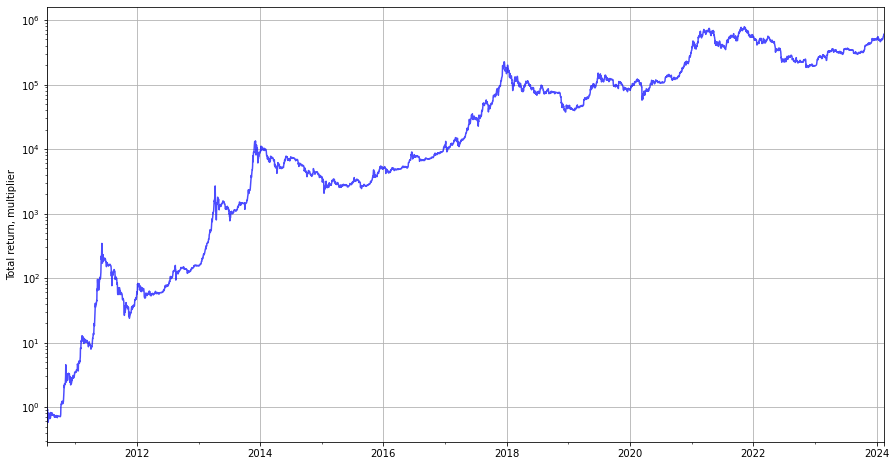

In [105]:
log_returns = np.log(result_df['portfolio_value']).diff().fillna(0)

cum_returns = log_returns.cumsum() 

mult_returns = np.exp(cum_returns)

ax = mult_returns.plot(figsize=(15,8), color='b', alpha=0.7)
ax.grid(axis='both')
ax.set_yscale('log')
ax.set_ylabel('Total return, multiplier')


In [106]:
DATE_FORMAT = '%Y-%m-%d'
first = result_df.iloc[0]
last = result_df.iloc[-1]

years = (last.name - first.name).days / 365.25

annualized_return = (last['portfolio_value']  / first['portfolio_value']) ** (1/years) - 1

print(
  """Annualized return (CAGR) is: %.2f%%
over the period of %.2f years
from %s to %s""" % (
    100 * annualized_return,
    years,
    first.name.strftime(DATE_FORMAT),
    last.name.strftime(DATE_FORMAT)
  )
)


Annualized return (CAGR) is: 166.55%
over the period of 13.58 years
from 2010-07-18 to 2024-02-14


## Коэфициент Шарпа

https://www.alt-invest.ru/lib/sharpe_ratio/

In [107]:
TRADING_DAYS_YEARLY = 365
RISK_FREE_RATE = 0.01 # 1%

annual_return = np.exp(log_returns.mean() * TRADING_DAYS_YEARLY) - 1
annual_volatility = log_returns.std() * np.sqrt(TRADING_DAYS_YEARLY)

sharpe_ratio = (annual_return - RISK_FREE_RATE) / annual_volatility

annualized_downside = log_returns.loc[log_returns<0].std() * np.sqrt(TRADING_DAYS_YEARLY)
sortino_ratio = (annual_return - RISK_FREE_RATE) / annualized_downside  

sortino_ratio = (annual_return - RISK_FREE_RATE) / annualized_downside  

print(
  f"""Annulaized return {(annual_return * 100):.2f}%
Annualized volatility {(annual_volatility * 100):.2f}%
Sharpe ratio {sharpe_ratio:.2f}
Sortino ratio {sortino_ratio:.2f}
""" 
)

Annulaized return 166.32%
Annualized volatility 94.98%
Sharpe ratio 1.74
Sortino ratio 2.08



# Кореляция с Американскими акциями

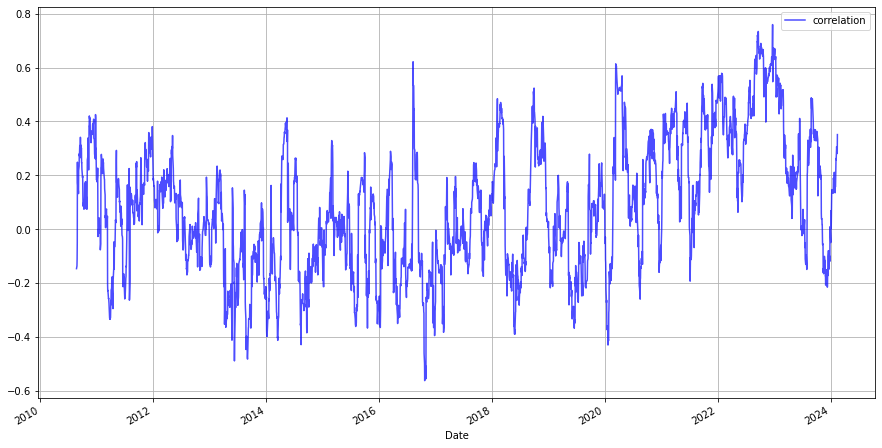

In [108]:
import portfolio_tools as pt
import history_loader as h

window = 30 # days
corr = h.load_max_history(['SPY'])['Adj Close'].pct_change().join(df['Close'].pct_change()).dropna().rolling(window=window).corr().dropna().iloc[::2]['BTC-USD']
corr = corr.reset_index()[['Date', 'BTC-USD']].rename({'BTC-USD': 'correlation'}, axis=1).set_index('Date')
corr.plot(figsize=(15,8), color='b', alpha=0.7)
plt.grid(axis='both')


In [109]:
corr.quantile([0.05, 0.5, 0.95]).rename_axis('квантиль').rename_axis('', axis=1)

,correlation
квантиль,
0.05,-0.290389
0.50,0.063788
0.95,0.510427


# Доходность по месяцам и годам

In [110]:
def montly_results(result_df):
  initial_value = result_df['portfolio_value'].iloc[0]

  grouping = pd.MultiIndex.from_tuples(
    zip(result_df.index.year, result_df.index.month),
    names=['year', 'month']
  )

  by_month = result_df.groupby(by=grouping).last()[['portfolio_value']]
  by_month = by_month.join(by_month.shift(1).add_prefix('prev_')).fillna(initial_value)

  table = pd.DataFrame(
    {
      'change': 100 * (by_month['portfolio_value'] / by_month['prev_portfolio_value'] - 1),
    },
    index = grouping
  ).dropna().reset_index()

  montly_results = table.pivot_table(index=['year'], columns=['month'], values=['change'])

  grouping = result_df.index.year
  by_year = result_df.groupby(by=grouping).last()[['portfolio_value']]
  by_year = by_year.join(by_year.shift(1).add_prefix('prev_')).fillna(initial_value)

  montly_results['total'] = 100 * (by_year['portfolio_value'] / by_year['prev_portfolio_value'] - 1)

  return montly_results

pd.options.display.float_format = lambda x: 'N/A' if np.isnan(x) else '{:,.2f}%'.format(x)
display(montly_results(result_df).fillna("n/a"))
pd.options.display.float_format = None 


change                                                                  \
month       1       2       3       4       5       6       7       8       9   
year                                                                            
2010      n/a     n/a     n/a     n/a     n/a     n/a -20.86% -11.63%   3.17%   
2011   73.33%  65.38%  -8.77% 346.09% 149.74%  84.20% -17.09% -38.58% -37.31%   
2012   16.13% -11.38%   1.00%   0.82%   4.67%  29.15%  39.76%   8.66%  22.05%   
2013   51.07%  63.55% 178.70%  49.66%  -7.48% -24.30%   0.42%  32.22%  -4.91%   
2014   11.99% -35.88% -15.71%  -2.76%  39.79%   2.58%  -9.07% -17.76% -19.20%   
2015  -32.15%  16.88%  -4.00%  -2.80%  -2.78%  14.12%   8.17% -18.99%   2.71%   
2016  -14.63%  18.92%  -4.91%   8.23%  18.35%  26.46%  -6.93%  -8.56%   6.31%   
2017   -0.06%  23.07%  -9.33%  24.84%  72.87%   7.28%  14.95%  65.80%  -8.64%   
2018  -26.65%   1.41% -32.82%  33.47% -19.01% -14.69%  20.97%  -9.23%  -5.82%   
2019   -7.98%  11.16%   7.62%  30.63%  58.87%  26.03%  -6.30%  -4.78% -13.44%   
2020   30.13%  -8.64% -24.46%  35.52%   9.20%  -4.20%  20.57%   5.92%  -8.02%   
2021   14.41%  36.60%  29.91%  -1.80% -35.44%  -5.97%  18.27%  13.67%  -7.01%   
2022  -16.68%  12.20%   7.22% -16.63% -18.34% -38.30%  19.92% -14.04%  -3.12%   
2023   39.90%  -0.05%  23.24%   2.81%  -7.10%  11.95%  -4.13% -11.24%   4.01%   
2024    0.23%  21.43%     n/a     n/a     n/a     n/a     n/a     n/a     n/a   

                                  total  
month      10      11      12            
year                                     
2010  210.99%   8.16%  44.09%   249.65%  
2011  -36.81%  -8.56%  58.98% 1,474.00%  
2012   -9.67%  12.18%   7.52%   186.11%  
2013   61.03% 467.41% -32.65% 5,506.92%  
2014  -12.81%  11.96% -15.22%   -57.80%  
2015   32.25%  20.64%  14.10%    34.52%  
2016   14.62%   6.40%  30.49%   125.14%  
2017   48.12%  53.80%  39.77% 1,331.50%  
2018   -4.32% -36.84%  -6.30%   -73.01%  
2019   10.19% -17.38%  -5.14%    92.02%  
2020   28.45%  42.84%  46.93%   303.16%  
2021   39.96%  -7.12% -18.90%    59.57%  
2022    5.48% -16.31%  -3.59%   -64.21%  
2023   28.54%   8.63%  12.98%   157.32%  
2024      n/a     n/a     n/a    21.70%

In [111]:
max_price = df.Close['BTC-USD'].max()

print('Possible next min price:')
for dd in [0.8, 0.9]:
    print(f'DD {dd*100}%: {max_price * (1-dd):.0f} USD')

Possible next min price:
DD 80.0%: 13509 USD
DD 90.0%: 6754 USD


# Анализ просадок

2024-02-10   -29.404084
2024-02-11   -28.844006
2024-02-12   -25.984998
2024-02-13   -26.679180
2024-02-14   -23.319623
Name: portfolio_value, dtype: float64

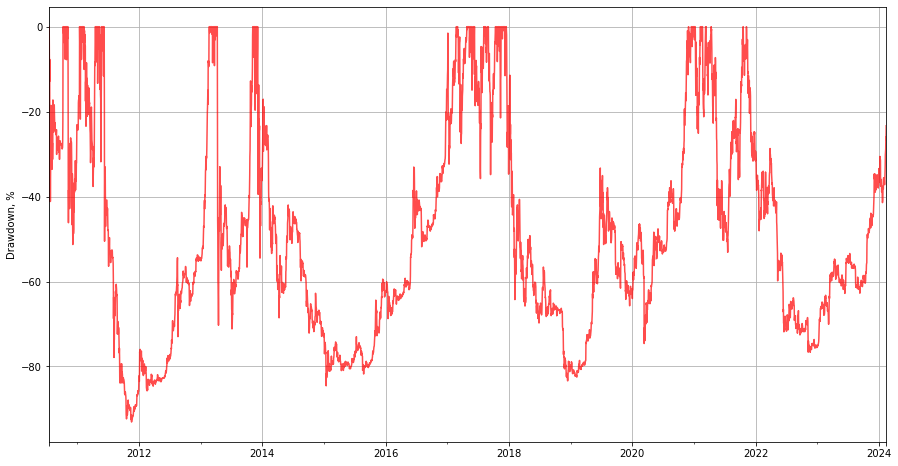

In [112]:
cum_returns = log_returns.cumsum() 
last_peak = cum_returns.cummax()

log_dd = (cum_returns - last_peak).dropna()

pct_dd = (np.exp(log_dd) - 1) * 100
perf = (np.exp(cum_returns) - 1) * 100

ax = pct_dd.plot(figsize=(15,8), color='r', alpha=0.7)
ax.grid(axis='both')
ax.set_ylabel('Drawdown, %')

# plt.savefig('drawdown_evaluation.png')
pct_dd.tail()


<a id="DD"></a>

In [113]:

import portfolio_tools as pt

dd_streaks = pt.DrawdownStreaks(log_returns, is_logreturns=True)
dd_streaks

Longest drawdowns


,days,months,years,from_date,to_date,max_depth,max_dd_date,days_d,months_d,years_d
0,1176,38.64,3.22,2013-12-05,2017-02-23,-84.55,2015-01-14,405,13.31,1.11
1,1079,35.45,2.95,2017-12-17,2020-11-30,-83.38,2018-12-15,363,11.93,0.99
2,827,27.17,2.26,2021-11-09,2024-02-14,-76.65,2022-11-21,377,12.39,1.03
3,622,20.44,1.70,2011-06-09,2013-02-20,-93.07,2011-11-18,162,5.32,0.44
4,209,6.87,0.57,2013-04-10,2013-11-05,-71.16,2013-07-05,86,2.83,0.24
5,188,6.18,0.51,2021-04-14,2021-10-19,-53.12,2021-07-20,97,3.19,0.27
6,81,2.66,0.22,2010-07-19,2010-10-08,-41.14,2010-07-22,3,0.10,0.01
7,68,2.23,0.19,2010-11-07,2011-01-14,-51.28,2010-12-05,28,0.92,0.08
8,66,2.17,0.18,2011-02-10,2011-04-17,-37.61,2011-04-04,53,1.74,0.15
9,54,1.77,0.15,2017-06-12,2017-08-05,-35.77,2017-07-16,34,1.12,0.09


Deepest drawdowns


,days,months,years,from_date,to_date,max_depth,max_dd_date,days_d,months_d,years_d
0,622,20.44,1.70,2011-06-09,2013-02-20,-93.07,2011-11-18,162,5.32,0.44
1,1176,38.64,3.22,2013-12-05,2017-02-23,-84.55,2015-01-14,405,13.31,1.11
2,1079,35.45,2.95,2017-12-17,2020-11-30,-83.38,2018-12-15,363,11.93,0.99
3,827,27.17,2.26,2021-11-09,2024-02-14,-76.65,2022-11-21,377,12.39,1.03
4,209,6.87,0.57,2013-04-10,2013-11-05,-71.16,2013-07-05,86,2.83,0.24
5,188,6.18,0.51,2021-04-14,2021-10-19,-53.12,2021-07-20,97,3.19,0.27
6,68,2.23,0.19,2010-11-07,2011-01-14,-51.28,2010-12-05,28,0.92,0.08
7,81,2.66,0.22,2010-07-19,2010-10-08,-41.14,2010-07-22,3,0.10,0.01
8,66,2.17,0.18,2011-02-10,2011-04-17,-37.61,2011-04-04,53,1.74,0.15
9,54,1.77,0.15,2017-06-12,2017-08-05,-35.77,2017-07-16,34,1.12,0.09


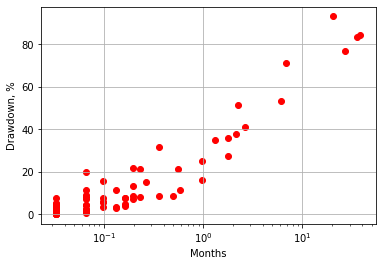

In [114]:
dd_df = dd_streaks.to_dataframe()
plt.scatter(y=-dd_df.max_depth, x=dd_df.months, color='r')
plt.xlabel('Months')
plt.ylabel('Drawdown, %')
plt.grid(axis='both')
# plt.yscale('log')
plt.xscale('log')

# Квантили просадок

Квантиль - значение случайной величины (просадка по закрытию дня)  
которое не превышается с заданой вероятностью

Quantiles:
50.0% of days expected drawdown is no more than 55.00%
75.0% of days expected drawdown is no more than 67.28%
95.0% of days expected drawdown is no more than 82.03%
99.0% of days expected drawdown is no more than 89.36%
Max DD was 93.07%
Last DD (2024-02-14) was 23.32%


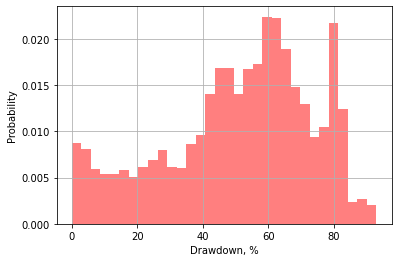

In [115]:
# from scipy.stats import expon

nonzero_dd_days = -pct_dd[pct_dd < 0].sort_values()
ax = nonzero_dd_days.hist(bins=32, alpha=0.5, density=True, color='red')
ax.set_xlabel('Drawdown, %')
ax.set_ylabel('Probability')

# params = expon.fit(nonzero_dd_days)

def quantiles(p):
  return (
    # expon.ppf(p, *params),
    None,
    np.quantile(nonzero_dd_days, p)
  )

# xs = np.linspace(quantiles(0.001)[0], quantiles(0.999)[0], 100)
# plt.plot(xs, expon.pdf(xs, *params))

def print_quantile(p):
  (theoretical, real) = quantiles(p)
  # print(f'{p * 100}% of time expected drawdown is no more than {theoretical:.2f}% theoretically or {real:.2f}% actually')
  print(f'{p * 100}% of days expected drawdown is no more than {real:.2f}%')

print('Quantiles:')
for p in [0.50, 0.75, 0.95, 0.99]:
  print_quantile(p)

print(f'Max DD was {nonzero_dd_days.iloc[0]:.2f}%')
print(f'Last DD ({pct_dd.index[-1].date()}) was {-pct_dd.iloc[-1]:.2f}%')

# Какой будет следующий минимум?

In [116]:
max_price = df.max().Close['BTC-USD']

print(f'max price {max_price:.0f}$')

for q in [0.5, 0.75, 0.95, 0.99]:
  print(f'цена {max_price * (1-quantiles(q)[1]/100):.0f}$, вероятность {(1-q)*100:.0f}%')


max price 67545$
цена 30393$, вероятность 50%
цена 22099$, вероятность 25%
цена 12135$, вероятность 5%
цена 7188$, вероятность 1%


5% = 1 к 19

1% = 1 к 99

<a id="seasons"></a>

# Сезонность

(черная линия - среднее изменение)


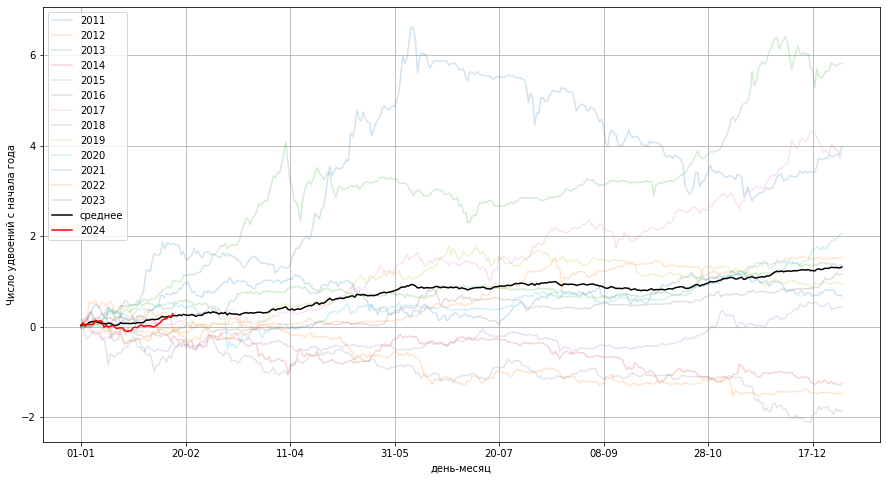

In [117]:
import math

log2_returns = math.log2(math.e) * log_returns

years = sorted(set(map(lambda i: i.year, log2_returns.index)))
full_years = years[1:-1]
last_year = years[-1]


def reset_year_on_index(dt):
    return f"{dt.day:02}-{dt.month:02}"
    # return datetime.date(1800, ts.month, ts.day)


def reset_year(year_rets):
    year_rets.index = [reset_year_on_index(ts) for ts in year_rets.index]
    return year_rets


def get_year_rets(year: int):
    return reset_year(log2_returns[log2_returns.index.year == year].copy())


by_year = pd.DataFrame()

for year in full_years:
    by_year[year] = get_year_rets(year)

t = by_year.transpose()
# ci_all_years = [
#     np.quantile(years, [0.05, 0.5, 0.95]) for (i, years) in t.items()
# ]

# pd.DataFrame(ci_all_years, columns=['5%', 'median', '95%'], index=by_year.index)

mean_all_years = [np.mean(years) for (i, years) in t.items()]

ax = by_year.cumsum().plot(figsize=(15, 8), alpha=0.2)
ax.grid(axis="both")
ax.set_ylabel("Число удвоений с начала года")
ax.set_xlabel("день-месяц")

mean_all_years_df = pd.DataFrame(
    mean_all_years, columns=["среднее"], index=by_year.index
)
ax.plot(mean_all_years_df.cumsum(), color="black", label="среднее")
ax.plot(get_year_rets(last_year).cumsum(), label=last_year, color="red")

ax.legend()

None